In [2]:
import numpy as np
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [3]:
def sample_images_raw(fname):
    image_data = loadmat(fname)['IMAGESr']

    patch_size = 12
    n_patches = 10000
    image_size = image_data.shape[0]
    n_images = image_data.shape[2]

    patches = np.zeros(shape=(patch_size * patch_size, n_patches))

    for i in range(n_patches):
        image_id = np.random.randint(0, n_images)
        image_x = np.random.randint(0, image_size - patch_size)
        image_y = np.random.randint(0, image_size - patch_size)

        img = image_data[:, :, image_id]
        patch = img[image_x:image_x + patch_size, image_y:image_y + patch_size].reshape(-1)
        patches[:, i] = patch

    return patches

def display_network(A):
    opt_normalize = True
    opt_graycolor = True

    A = A - np.average(A)

    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    n = np.ceil(np.sqrt(col))
    m = np.ceil(col / n)
    
    img_shape1 = int(buf + m * (sz + buf))
    img_shape2 = int(buf + n * (sz + buf))
    image = np.ones(shape=(img_shape1, img_shape2))

    if not opt_graycolor:
        image *= 0.1

    k = 0
    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue
            clim = np.max(np.abs(A[:, k]))
            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1
    return image


def get_optimal_k(threshold, s):
    k = 0
    total_sum = np.sum(s)
    sum_ev = 0.0
    for i in range(s.size):
        sum_ev += s[i]     
        ratio = sum_ev / total_sum
        if ratio > threshold: break
        k += 1
    return k   

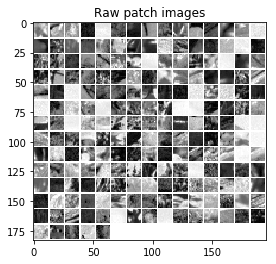

In [6]:
x = sample_images_raw('IMAGES_RAW.mat')

n, m = x.shape
random_sel = np.random.randint(0, m, 200)
image_x = display_network(x[:, random_sel])

fig = plt.figure()
plt.imshow(image_x, cmap=plt.cm.gray)
plt.title('Raw patch images')

x -= np.mean(x, axis=1).reshape(-1, 1)

Step 1

Text(0.5,1,'Covariance matrix of x_rot')

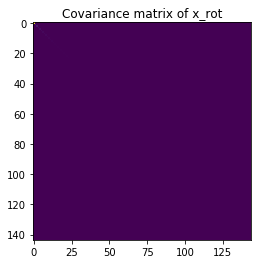

In [7]:
sigma = x.dot(x.T) / m 
U, s, V = np.linalg.svd(sigma)
x_rot = U.T.dot(x)

covar = np.cov(x_rot)

fig = plt.figure()
plt.imshow(covar)
plt.title('Covariance matrix of x_rot')

In [11]:
opt_k_99 = get_optimal_k(0.99, s)

x_tilde = x_rot[0:opt_k_99, :]
x_hat = U[:, 0:opt_k_99].dot(x_tilde)

image_x_hat_99 = display_network(x_hat[:, random_sel])

In [12]:
opt_k_90 = get_optimal_k(0.90, s)
x_tilde = x_rot[0:opt_k_90, :]
x_hat = U[:, 0:opt_k_90].dot(x_tilde)

image_x_hat_90 = display_network(x_hat[:, random_sel])

Text(0.5,1,'90% variance')

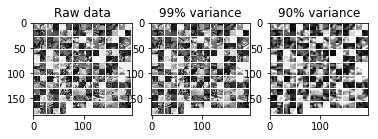

In [13]:
f, ax = plt.subplots(1, 3)
ax[0].imshow(image_x, cmap=plt.cm.gray)
ax[0].set_title('Raw data')
ax[1].imshow(image_x_hat_99, cmap=plt.cm.gray)
ax[1].set_title('99% variance')
ax[2].imshow(image_x_hat_90, cmap=plt.cm.gray)
ax[2].set_title('90% variance')

Step 4

Text(0.5,1,'PCA white Without Regulation')

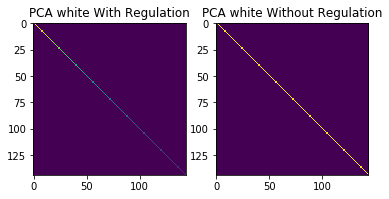

In [14]:
epsilon = 0.1
x_PCA_white = np.diag(1.0/np.sqrt(s + epsilon)).dot(x_rot)
x_PCA_white_without_regulation = np.diag(1.0/np.sqrt(s)).dot(x_rot)
covar = np.cov(x_PCA_white)
covar_without_regulation = np.cov(x_PCA_white_without_regulation)

f, ax = plt.subplots(1, 2)
ax[0].imshow(covar)
ax[0].set_title('PCA white With Regulation')
ax[1].imshow(covar_without_regulation)
ax[1].set_title('PCA white Without Regulation')

Step 5

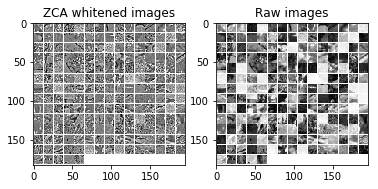

In [15]:
epsilon = 0.1
x_PCA_white = np.diag(1.0/np.sqrt(s + epsilon)).dot(x_rot)
x_ZCA_white = U.dot(x_PCA_white)

image_raw = display_network(x[:, random_sel])
image_ZCA_white = display_network(x_ZCA_white[:, random_sel])

f, ax = plt.subplots(1, 2)
ax[0].imshow(image_ZCA_white, cmap=plt.cm.gray)
ax[0].set_title('ZCA whitened images')
ax[1].imshow(image_raw, cmap=plt.cm.gray)
ax[1].set_title('Raw images')
plt.show()

plt.imsave('pca_raw.png', image_raw, cmap=plt.cm.gray)
plt.imsave('pca_zca_white.png', image_ZCA_white, cmap=plt.cm.gray)